In [ ]:
# Tensorflow는 GPU 지원이 가능

# Tensorflow를 활용한 SSD Object Detection

In [1]:
!rm -rf DLCV
!git clone https://github.com/chulminkw/DLCV.git
# DLCV 디렉토리가 Download되고 DLCV 밑에 Detection과 Segmentation 디렉토리가 있는 것을 확인
# tensorflow 1.15을 설치합니다. 자동으로 tensorflow 2.2가 1.15로 downgrade 됩니다. 
!pip install tensorflow-gpu==1.15.2 
# keras 2.3를 설치합니다. 
!pip install keras==2.3.0

import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

Cloning into 'DLCV'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (71/71), done.
Receiving objects: 100% (234/234), 142.72 MiB | 46.92 MiB/s, done.
remote: Total 234 (delta 32), reused 0 (delta 0), pack-reused 159
Resolving deltas: 100% (89/89), done.
     |████████████████████████████████| 411.0MB 43kB/s 
     |████████████████████████████████| 512kB 47.6MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 3.8MB 39.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=6f361339f6676e3828fd14b3a445c92a903a3fc5e903d0ede2bc54ee979629a7
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll h

Using TensorFlow backend.


In [2]:
# Pretrained 모델과 Config 파일 다운로드 받기
!rm -rf /content/DLCV/Detection/ssd//pretrained
!mkdir /content/DLCV/Detection/ssd/pretrained
# pretrained 디렉토리가 생성되었는지 확인 합니다. 
%cd /content/DLCV/Detection/ssd
!ls

### coco 데이터 세트로 pretrained 된 ssd 파일과 config용 graph pbtxt 다운로드 
%cd /content/DLCV/Detection/ssd/pretrained
!echo "##### downloading pretrained weight file and config pbtxt file"
!wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
!wget https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt


# tar 파일 압축 해제
!echo "##### uncompressing tar file"
!tar -xvf ssd_inception*.gz

# config용 pbtxt 파일의 이름을 graph.pbtxt로 변경
# echo "renaming pbtxt file name"
!mv /content/DLCV/Detection/ssd/pretrained/ssd_inception*.pbtxt /content/DLCV/Detection/ssd/pretrained/ssd_inception_v2_coco_2017_11_17/graph.pbtxt

# tar 파일 삭제
!echo "##### deleting tar file" 
!rm *.gz

# weight파일과 config 파일이 있는 pretrained/faster_rcnn_resnet50_coco_2018_01_28 디렉토리 내부 확인 
!echo "##### check out pretrained/ssd_inception_v2_coco_2017_11_17"
!ls /content/DLCV/Detection/ssd/pretrained/ssd_inception_v2_coco_2017_11_17

/content/DLCV/Detection/ssd
OpenCV_SSD_이미지와_영상_Detection.ipynb
pretrained
SSD_Face_Detection.ipynb
Tensorflow_SSD_이미지와_영상_Detection.ipynb
/content/DLCV/Detection/ssd/pretrained
##### downloading pretrained weight file and config pbtxt file
--2021-04-13 08:06:24--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.115.128, 2607:f8b0:4004:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.115.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278126337 (265M) [application/x-tar]
Saving to: ‘ssd_inception_v2_coco_2017_11_17.tar.gz’

ssd_inception_v2_co 100%[===================>] 265.24M   104MB/s    in 2.5s    

2021-04-13 08:06:26 (104 MB/s) - ‘ssd_inception_v2_coco_2017_11_17.tar.gz’ saved [278126337/278126337]

--2021-04-13 08:06:26--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_incep

In [3]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

Detection 수행시간: 3.51694917678833 초


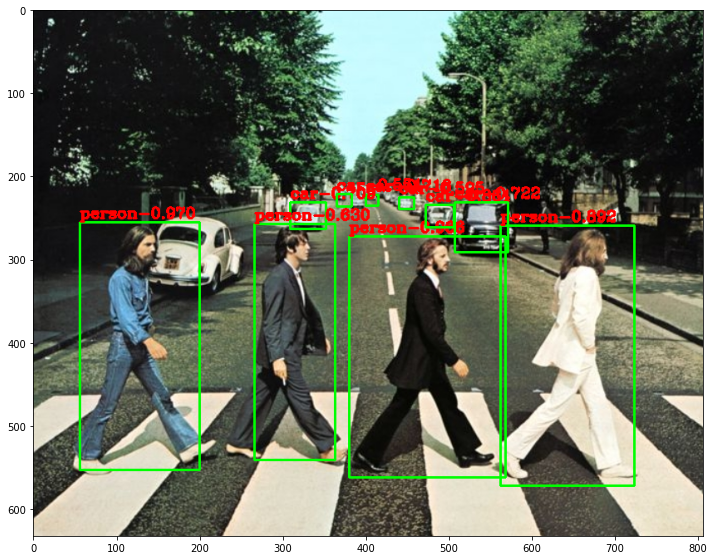

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import time
%matplotlib inline

default_dir = '/content/DLCV'
default_ssd_dir='/content/DLCV/Detection/ssd'

# Tensorflow로 SSD 모델 로드
with tf.gfile.FastGFile(os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'), 'rb') as f:
  graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())

# Tensorflow로 Object Detection 모델 수행
with tf.Session() as sess:
  sess.graph.as_default()
  tf.import_graph_def(graph_def, name='')

  img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
  draw_img = img.copy()
  # 높이, 너비 
  height = img.shape[0]
  width = img.shape[1]
  input = cv2.resize(img, (300, 300)) # SSD 모델이 요구하는 입력 사이즈로 resize
  # print(input.shape) -> (300, 300, 3)
  # 입력 이미지를 RGB로 변경
  input = input[:, :, [2, 1, 0]]
  start = time.time()

  out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                  sess.graph.get_tensor_by_name('detection_scores:0'),
                  sess.graph.get_tensor_by_name('detection_boxes:0'),
                  sess.graph.get_tensor_by_name('detection_classes:0')],
                 feed_dict={'image_tensor:0': input.reshape(1, input.shape[0], input.shape[1], 3)})
  
  green = (0, 255, 0)
  red = (0, 0, 255)
  num_detections = int(out[0][0]) # 바운딩 박스 개수
  for i in range(num_detections):
    class_id = int(out[3][0][i])
    score = float(out[1][0][i])
    bbox = [float(v) for v in out[2][0][i]]
    if score > 0.4:
      # 좌표 계산 -> y1, x1, y2, x2 순서로 되어있음
      left = int(bbox[1] * width)
      top = int(bbox[0] * height)
      right = int(bbox[3] * width)
      bottom = int(bbox[2] * height)

      cv2.rectangle(draw_img, (left, top), (right, bottom),
                    green, thickness=2)
      caption = f"{labels_to_names[class_id]}-{score :.3f}"
      cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_COMPLEX,
                  0.6, red, 2)
      
  print("Detection 수행시간:", time.time() - start, '초')

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [9]:
# 함수화 시키기

def get_tensor_detected_image(sess, img_array, score_threshold, use_copied_array):

  height = img_array.shape[0]
  width = img_array.shape[1]
  if use_copied_array:
    draw_img = img_array.copy()
  else:
    draw_img = img_array

  input = cv2.resize(img_array, (300, 300))
  input = input[:, :, [2, 1, 0]] # BGR -> RGB

  start = time.time()

  out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                  sess.graph.get_tensor_by_name('detection_scores:0'),
                  sess.graph.get_tensor_by_name('detection_boxes:0'),
                  sess.graph.get_tensor_by_name('detection_classes:0')],
                 feed_dict={'image_tensor:0': input.reshape(1, input.shape[0], input.shape[1], 3)})
  green = (0, 255, 0)
  red = (0, 0 ,255)

  num_detections = int(out[0][0])
  for i in range(0, num_detections):
    class_id = int(out[3][0][i])
    score = float(out[1][0][i])
    bbox = [float(v) for v in out[2][0][i]]
    if score > score_threshold:
      # 좌표 계산 y1, x1, y2, x2로 되어 있음
      left = int(bbox[1] * width)
      top = int(bbox[0] * height)
      right = int(bbox[3] * width)
      bottom = int(bbox[2] * height)

      caption = f"{labels_to_names[class_id]}-{score :.3f}"
      cv2.rectangle(draw_img, (left, top), (right, bottom),
                    green, thickness=2)
      cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_COMPLEX,
                  0.4, red, 1)
  print("Detection 수행시간:", time.time() - start, '초')
  return draw_img
    

# Video Object Detection 수행

In [11]:
default_dir = '/content/DLCV'
default_ssd_dir = '/content/DLCV/Detection/ssd'

video_input_path = os.path.join(default_dir, 'data/video/Night_Day_Chase.mp4')
# linux에서 video output의 확장자는 반드시 avi 로 설정 필요. 
video_output_path = os.path.join(default_dir, 'data/output/Night_Day_Chase_tensor_ssd_incep01.avi')

cap = cv2.VideoCapture(video_input_path)
codec = cv2.VideoWriter_fourcc(*"XVID")
vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
vid_fps = cap.get(cv2.CAP_PROP_FPS)
frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

vid_writer = cv2.VideoWriter(video_output_path, codec,
                             vid_fps, vid_size)
print("총 프레임 개수:", frame_cnt)

총 프레임 개수: 1383


In [13]:
green = (0, 255, 0)
red = (0, 0, 255)

with tf.gfile.FastGFile(os.path.join(default_ssd_dir, 'pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb'), 'rb') as f:
  graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())

with tf.Session() as sess:
  sess.graph.as_default()
  # pretrained 모델 로드
  tf.import_graph_def(graph_def, name='')
  index = 0
  while True:
    hasFrame, imgFrame = cap.read()
    if not hasFrame:
      print('더 이상 처리할 프레임이 없습니다!')
      break
    
    draw_img_frame = get_tensor_detected_image(sess, imgFrame,
                                               0.4, True)
    vid_writer.write(draw_img_frame)

vid_writer.release()
cap.release()

Detection 수행시간: 3.934736728668213 초
Detection 수행시간: 0.10042381286621094 초
Detection 수행시간: 0.09792113304138184 초
Detection 수행시간: 0.08733153343200684 초
Detection 수행시간: 0.09351539611816406 초
Detection 수행시간: 0.08403134346008301 초
Detection 수행시간: 0.08278703689575195 초
Detection 수행시간: 0.07973480224609375 초
Detection 수행시간: 0.08419442176818848 초
Detection 수행시간: 0.08416080474853516 초
Detection 수행시간: 0.08461308479309082 초
Detection 수행시간: 0.08368849754333496 초
Detection 수행시간: 0.08170008659362793 초
Detection 수행시간: 0.08050251007080078 초
Detection 수행시간: 0.08269095420837402 초
Detection 수행시간: 0.09120512008666992 초
Detection 수행시간: 0.08182001113891602 초
Detection 수행시간: 0.08728194236755371 초
Detection 수행시간: 0.08611011505126953 초
Detection 수행시간: 0.08082246780395508 초
Detection 수행시간: 0.08616280555725098 초
Detection 수행시간: 0.08539390563964844 초
Detection 수행시간: 0.08368825912475586 초
Detection 수행시간: 0.08229446411132812 초
Detection 수행시간: 0.08172464370727539 초
Detection 수행시간: 0.08166074752807617 초
Detection 수행시간